# Thermochemical Benchmark: closed shell reactions with core correlation

Bak et al., [J. Chem. Phys. 112, 9229–9242 (2000)](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Bak2000_reactions'
parallel = None  # how many jobs to run at once

In [3]:
methods = ['HF', 'MP2', 'CCSD', 'CCSD(T)', 'CCSD(T)-F12A', 'CCSD(T)-F12B', 'CCSD(T)-F12C']
bases = ['cc-pCVDZ', 'cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z']

In [4]:
db = pymolpro.database.load("Bak2000_reactions")

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, method, basis + '-F12' if 'F12' in method else basis,
                                                       location=project_name, backend=backend,
                                                       preamble="core,small", parallel=parallel)
        if results[method][basis].failed: print(method, basis, 'failed', results[method][basis].project_directory)

CCSD(T)-F12A cc-pCV5Z failed /Users/peterk/trees/pymolpro/docs/source/examples/Bak2000_reactions/ee88723c
CCSD(T)-F12B cc-pCV5Z failed /Users/peterk/trees/pymolpro/docs/source/examples/Bak2000_reactions/7719cc98
CCSD(T)-F12C cc-pCV5Z failed /Users/peterk/trees/pymolpro/docs/source/examples/Bak2000_reactions/8966d244


In [6]:
for method in methods:
    for result in pymolpro.database.basis_extrapolate(results[method].values(), results['HF'].values()):
        results[method][result.basis] = result
    for basis in results[method]:
        if basis not in bases: bases.append(basis)

In [7]:
pd.set_option('display.precision', 2)
method_errors = \
    pymolpro.database.analyse([results[method]['cc-pCVQZ' if 'F12' in method else 'cc-pCV[45]Z'] for method in methods],
                              db, 'kJ/mol')['reaction statistics']
with open(project_name + '.method_errors.tex', 'w') as tf:
    tf.write(
        '\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi')  # or \usepackage{booktabs}
    tf.write(method_errors.style.format(precision=2).to_latex(hrules=True, multicol_align='c', caption='Method errors'))
method_errors

,HF,MP2,CCSD,CCSD(T),CCSD(T)-F12A,CCSD(T)-F12B,CCSD(T)-F12C
,cc-pCV[45]Z,cc-pCV[45]Z,cc-pCV[45]Z,cc-pCV[45]Z,cc-pCVQZ-F12,cc-pCVQZ-F12,cc-pCVQZ-F12
MAD,29.06,15.42,9.93,1.19,1.12e+00,1.13,1.21
MAXD,113.66,51.83,17.75,3.49,2.27e+00,2.11,3.00
RMSD,40.69,21.57,11.04,1.43,1.27e+00,1.25,1.38
MSD,9.25,-11.94,-6.81,-0.83,-1.09e-03,0.02,-0.40
STDEVD,41.24,18.70,9.04,1.22,1.32e+00,1.30,1.38


In [8]:
pd.set_option('display.precision', 2)
basis_errors = \
    pymolpro.database.analyse([results['CCSD(T)'][basis] for basis in bases if basis in results['CCSD(T)']], db,
                              'kJ/mol')['reaction statistics']
with open(project_name + '.basis_errors.tex', 'w') as tf:
    tf.write(
        '\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi')  # or \usepackage{booktabs}
    tf.write(basis_errors.style.format(precision=2).to_latex(hrules=True, multicol_align='c', caption='Basis errors'))
basis_errors

CCSD(T)                                                               
       cc-pCVDZ cc-pCVTZ cc-pCVQZ cc-pCV5Z cc-pCV[23]Z cc-pCV[34]Z cc-pCV[45]Z
MAD       36.73    12.05     3.70     1.30        4.37        1.33        1.19
MAXD      65.92    21.33     6.97     3.00       10.79        3.15        3.49
RMSD      41.66    13.71     4.10     1.50        5.37        1.64        1.43
MSD       33.39    11.31     3.02     0.39        2.70       -1.13       -0.83
STDEVD    25.92     8.07     2.88     1.51        4.83        1.23        1.22

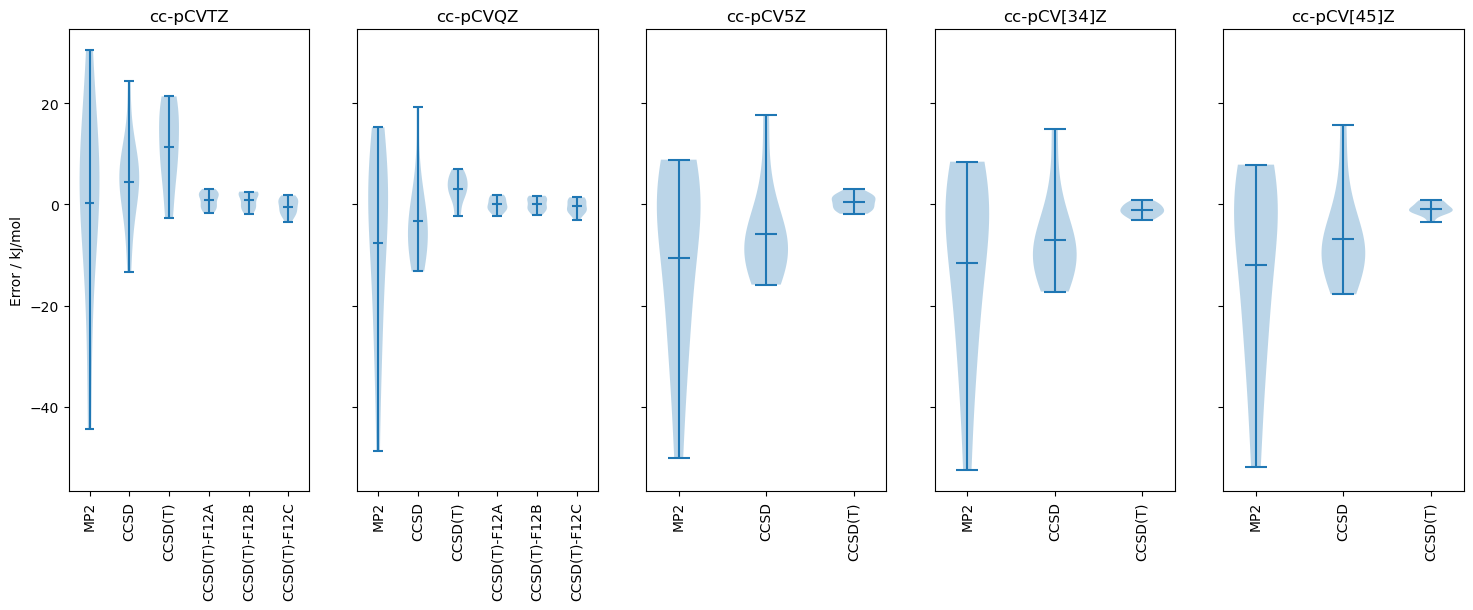

In [10]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z', 'cc-pCV[34]Z', 'cc-pCV[45]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    labels = []
    for method in methods_pruned:
        if bases_pruned[pane] in results[method] and results[method][bases_pruned[pane]].reaction_energies:
            data.append(
                pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                          db, 'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
            )
            labels.append(method)
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(labels) + 1), labels=labels, rotation=90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")